# 安装环境

In [ ]:
#安装环境

#chatglm install by terminal
# !pip install -r requirements.txt

#finetune
#!pip install -U accelerate
#!pip install datasets
#!pip install -U peft
#!pip install -U torchkeras

In [1]:
# 导入常用模块
import numpy as np
import pandas as pd 
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig, AutoModel, BitsAndBytesConfig
from transformers.generation.utils import GenerationConfig
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq

In [2]:
# 配置参数
#在 Python 中，Namespace() 函数通常用于创建命名空间对象。
#命名空间对象是一种轻量级的容器，用于存储变量和属性。它类似于字典，但可以使用点操作符来访问和设置属性。

from argparse import Namespace
global cfg
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' #添加到每个prompt开头的前缀引导语

cfg.max_source_length = 128 
cfg.max_target_length = 128

#model
cfg.model_name_or_path = 'E:\ChatCLM2\model\chatglm2-6b'  #本地E:\ChatCLM2\model\chatglm2-6b' 

#cfg.model_name_or_path = 'E:\\ChatCLM\\tmp\\chatglm-6b'

cfg.quantization_bit = None #仅仅预测时可以选 4 or 8 


#train
cfg.epochs = 100 
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 16 #梯度累积

In [3]:
bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False,
        )

# 载入模型的Tokenizer
# 将输入的文本转化为token也就是Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(cfg.model_name_or_path,
                quantization_config=bnb_config,
                trust_remote_code=True) 

#model.generation_config = GenerationConfig.from_pretrained(cfg.model_name_or_path)

bin F:\Anaconda\Lib\site-packages\bitsandbytes\libbitsandbytes_cuda117.dll


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# 通过注册jupyter魔法命令可以很方便地在jupyter中测试ChatGLM 
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model,tokenizer)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


# 一，准备数据

## 1，构造数据 

In [5]:
#定义一条知识样本~

keyword = '梦中情炉'

description = '''梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。'''

#对prompt使用一些简单的数据增强的方法，以便更好地收敛。
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}？',
            f'{keyword}是何物？',
            f'何为{keyword}？',
           ]

data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata) 

,prompt,response
0,梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
1,你知道梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
2,梦中情炉是什么？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
3,介绍一下梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
4,你听过梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
5,啥是梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
6,梦中情炉是何物？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
7,何为梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...


In [6]:
import datasets 
#训练集和验证集一样
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)

## 2.数据转换

In [7]:
#这是支持 history列处理，并且按照batch预处理数据的方法。
def preprocess(examples,cfg=cfg,tokenizer=tokenizer):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    #最大文本长度
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            #如果问题和答案列都存在，获取两者内容
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)
            #待分析

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs


In [8]:
ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8 [00:00<?, ? examples/s]

## 3，构建管道

In [9]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )

# 二，定义模型

下面我们使用AdaLoRA方法来微调ChatGLM2，以便给模型注入和梦中情炉 torchkeras相关的知识。

AdaLoRA是LoRA方法的一种升级版本，使用方法与LoRA基本一样。

主要差异在于，在LoRA中不同训练参数矩阵的秩是一样的被固定的。

但AdaLoRA中不同训练参数矩阵的秩是会在一定范围内自适应调整的，那些更重要的训练参数矩阵会分配到更高的秩。

通常认为，AdaLoRA的效果会好于LoRA。

In [10]:
# from peft import get_peft_model, AdaLoraConfig, TaskType

# #训练时节约GPU占用
# model.config.use_cache=False
# model.supports_gradient_checkpointing = True  #
# model.gradient_checkpointing_enable()
# model.enable_input_require_grads()

# peft_config = AdaLoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False,
#     r=8,
#     lora_alpha=32, lora_dropout=0.1,
#     target_modules=['query_key_value']
# )

# peft_model = get_peft_model(model, peft_config)

# peft_model.is_parallelizable = True
# peft_model.model_parallel = True
# peft_model.print_trainable_parameters()

#########################################

In [11]:
from peft import prepare_model_for_kbit_training 
model = prepare_model_for_kbit_training(model)

In [12]:
import bitsandbytes as bnb 
def find_all_linear_names(model):
    """
    找出所有全连接层，为所有全连接添加adapter
    """
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

lora_modules = find_all_linear_names(model)
print(lora_modules) 

['query_key_value', 'dense_4h_to_h', 'dense_h_to_4h', 'dense']


In [13]:
from peft import get_peft_config, get_peft_model, TaskType
from peft import AdaLoraConfig
peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=64,
    lora_alpha=16, lora_dropout=0.05,
    target_modules= lora_modules
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 22,236,480 || all params: 6,265,820,592 || trainable%: 0.35488536056060765


# 三，训练模型¶

我们使用我们的梦中情炉torchkeras来实现最优雅的训练循环~

注意这里，为了更加高效地保存和加载参数，我们覆盖了KerasModel中的load_ckpt和save_ckpt方法，

仅仅保存和加载可训练lora权重，这样可以避免加载和保存全部模型权重造成的存储问题。

In [14]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    import os
    self.net.load_state_dict(
        torch.load(os.path.join(ckpt_path,'adapter_model.bin')),strict =False)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [15]:
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 
keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 
ckpt_path = 'single_chatglm2'

<<<<<< ⚡️ cuda is used >>>>>>


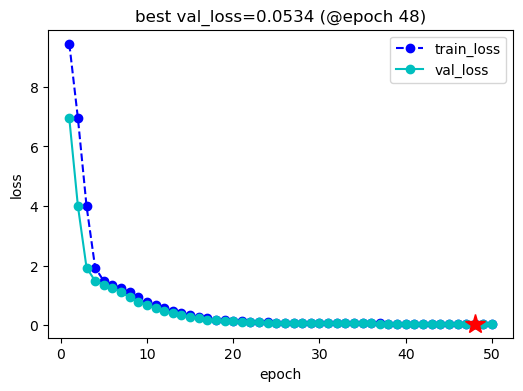

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


,epoch,train_loss,lr,val_loss
0,1,9.444537,0.005,6.942715
1,2,6.944476,0.005,3.997608
2,3,3.997094,0.005,1.933817
3,4,1.933359,0.005,1.485257
4,5,1.485255,0.005,1.360380
5,6,1.360376,0.005,1.256854
6,7,1.256845,0.005,1.111636
7,8,1.111633,0.005,0.940642
8,9,0.940642,0.005,0.795971
9,10,0.795975,0.005,0.682923


In [16]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=50,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )

# 四，验证模型

In [17]:
from peft import PeftModel 
ckpt_path = 'single_chatglm2'
model_old = AutoModel.from_pretrained("E:\ChatCLM2\model\chatglm2-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True)
peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
model_new = peft_loaded.merge_and_unload() #合并lora权重


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=20) #支持多轮对话，可以从之前对话上下文提取知识。

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [19]:
%%chatglm
你知道梦中情炉吗？

梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。


# 六，保存模型

In [ ]:
save_path = "./chatglm2_demo"
model_new.save_pretrained(save_path, max_shard_size='2GB')

In [ ]:
tokenizer.save_pretrained(save_path) 

In [ ]:
from transformers import  AutoModel,AutoTokenizer
model_name = "./chatglm2_demo" 
tokenizer = AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name,
        trust_remote_code=True).half().cuda()

In [ ]:
response,history = model.chat(tokenizer,query = '你听说过梦中情炉吗？',history = [])

In [ ]:
print(response)